# Portada

<p align="center">
<img src="https://www.uao.edu.co/wp-content/uploads/2023/01/3-Home-principal-Mockup-Escritorio-UAO-copy-05.png" width=30%>


<h1>UNIVERSIDAD AUTÓNOMA DE OCCIDENTE</strong></h1>
<h2>CALI - COLOMBIA</strong></h2>
<h2>19/05/2024</strong></h2>
<h1><strong>ESPECIALIZACIÓN EN INTELIGENCIA ARTIFICIAL</strong></h1>
<h2><strong>PROCESAMIENTO DE DATOS SECUENCIALES CON DEEP LEARNING</strong></h2>
<h2><strong>ENTREGA 1, PUNTO 3 </strong> PROCESAMIENTO DE SEÑALES DE AUDIO CON MODELOS CONVOLUCIÓN 2D USANDO COMO ENTRADA EL ESPECTROGRAMA Y MFCC
<h2><strong>PROFESOR:</strong> JESUS ALFONSO LOPEZ SOTELO</h2>
<h2><strong>ALUMNOS:</strong></h2>

*   <font color='red'> 2235918 Jairo Alberto Vélez Giraldo </font>
*   <font color='red'> 2235650 Guillermo Leon Zapata Álvarez </font>
*   <font color='red'> 2237389 Yoniliman Galvis Aguirre </font>

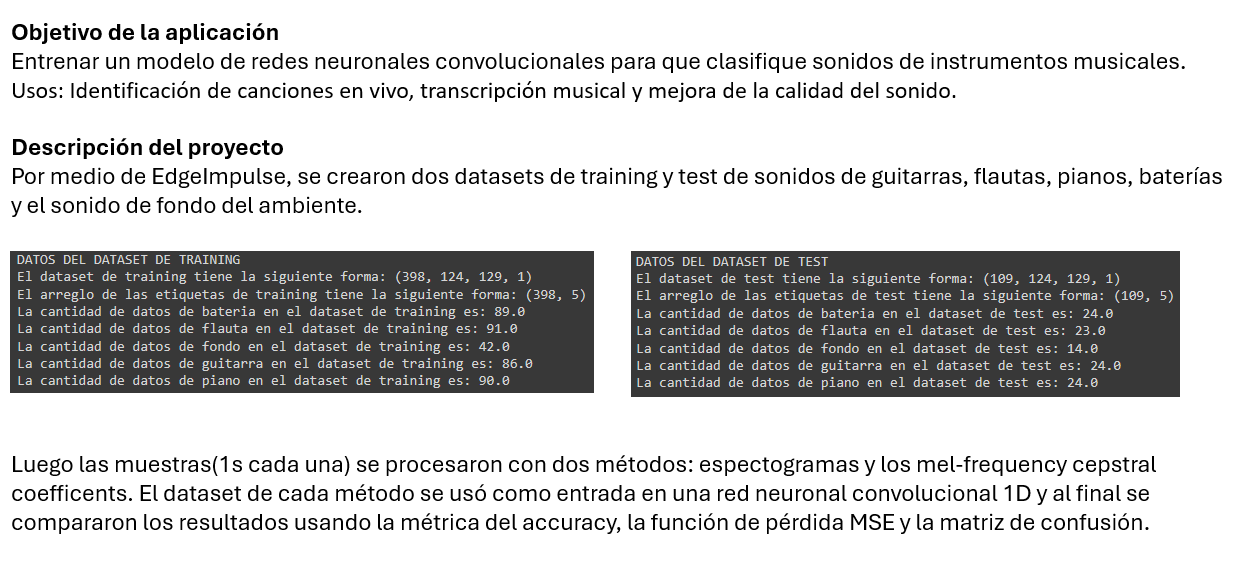

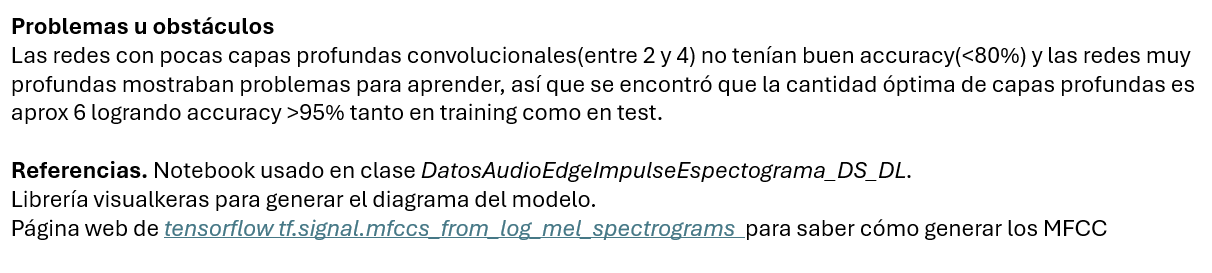

https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms

In [1]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.8 MB/s eta 0:00:00


In [2]:
!apt-get install fonts-freefont-ttf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-freefont-ttf
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,388 kB of archives.
After this operation, 6,653 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-freefont-ttf all 20120503-10build1 [2,388 kB]
Fetched 2,388 kB in 1s (3,312 kB/s)
Selecting previously unselected package fonts-freefont-ttf.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-freefont-ttf_20120503-10build1_all.deb ...
Unpacking fonts-freefont-ttf (20120503-10build1) ...
Setting up fonts-freefont-ttf (20120503-10build1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Se cargan las diferentes dependencias necesarias
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import visualkeras
from PIL import ImageFont
import os
import glob
from tensorflow.keras.layers import Dropout
from keras.optimizers import Adam
from matplotlib import cm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

<h1>Preprocesamiento y análisis de los archivos de audio</h1>

In [5]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    return wav

In [7]:
#Se guarda la cantidad de datos
RutaFile="/content/gdrive/MyDrive/datasets/instrumentos/training/bateria.4t3s6uuv.ingestion-54fbc688b-6hg76.s1.wav"
wave = load_wav_16k_mono(RutaFile)
wave_int = int(wave.shape[0])
print(wave_int)

16000


In [8]:
#Se sacan los stft y los espectogramas con ventanas de 255 de longitud y 128 de overlapping entre ventanas
def preprocess(wave):
    wav = wave[:wave_int]
    stft = tf.signal.stft(wav, frame_length=255, frame_step=128)
    spectrogram = tf.abs(stft)
    return spectrogram, stft

In [9]:
#Se indica el tamaño de los especogramas que al final servirá para definir el input shape de los modelos
espectrograma, __= preprocess(wave)
print('Waveform shape:', wave.shape)
print('Spectrogram shape:', espectrograma.shape)
print('Audio playback')
display.display(display.Audio(wave, rate=wave_int))

Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


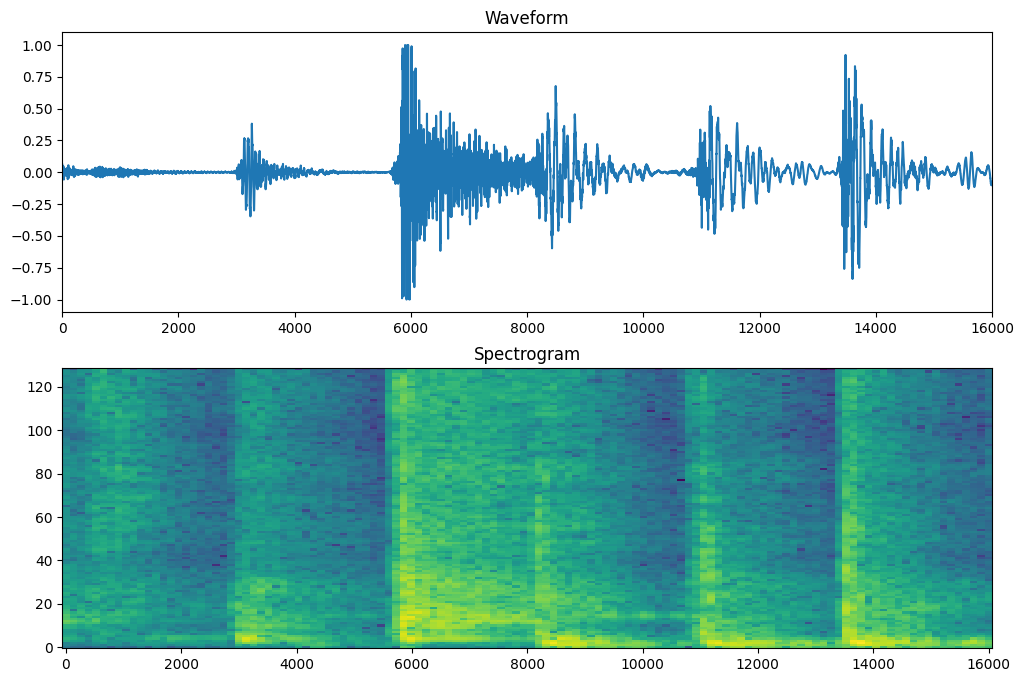

In [10]:
def plot_spectrogram(espectrograma, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(espectrograma.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

#Se muestra un ejemplo
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, wave_int])
plot_spectrogram(espectrograma.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

<h1>Procesamiento de los X y Y</h1>

In [11]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
def load_files(path, wave_axis1, wave_axis2):
  directory = path
  files = os.listdir(directory)
  files.sort()
  cantidadFiles = len(files)
  # Variable donde se almacenaron los datos leidos de los archivos *.json

  Datos=np.zeros((cantidadFiles, wave_axis1, wave_axis2))
  i = 0
  for file in files:
    RutaFile=directory + file
    wave = load_wav_16k_mono(RutaFile)
    espectrograma, __= preprocess(wave)
    Datos[i,:,:]=espectrograma
    i+=1

  #Matriz para guardar los X
  X=tf.expand_dims(Datos, axis=3)

  #Matriz para guardar los Y
  Y=np.zeros((X.shape[0],1))

  #Se crea un loop para contar automaticamente la cantidad de archivos de cada etiqueta
  classes = np.zeros(5)
  for file in files:
    if file.find('bateria') ==0:
      classes[0] += 1
    if file.find('flauta')  ==0:
      classes[1] += 1
    if file.find('fondo')   ==0:
      classes[2] += 1
    if file.find('guitarra')==0:
      classes[3] += 1
    if file.find('piano')   ==0:
      classes[4] += 1

  r0 = int(classes[0])
  r1 = int(classes[0]) + int(classes[1])
  r2 = int(classes[0]) + int(classes[1]) + int(classes[2])
  r3 = int(classes[0]) + int(classes[1]) + int(classes[2]) + int(classes[3])
  r4 = int(classes[0]) + int(classes[1]) + int(classes[2]) + int(classes[3]) + int(classes[4])

  for i in range(r0):
    Y[i]=0
  for i in range(r0, r1):
    Y[i]=1
  for i in range(r1, r2):
    Y[i]=2
  for i in range(r2, r3):
    Y[i]=3
  for i in range(r3, r4-1):
    Y[i]=4

  return X, Y, classes

In [12]:
#Rutas de acceso en el drive a las carpetas de training y testing
training_path = '/content/gdrive/MyDrive/datasets/instrumentos/training/'
test_path = '/content/gdrive/MyDrive/datasets/instrumentos/testing/'

In [13]:
#Se arman los datasets de training junto con las etiquetas
Xtrain, YtrainIni, classes_train = load_files(training_path,
                                     espectrograma.shape[0],
                                     espectrograma.shape[1])

#Se arman los datasets de test junto con las etiquetas
Xtest, YtestIni, classes_test = load_files(test_path,
                                     espectrograma.shape[0],
                                     espectrograma.shape[1])

#Se arman los datasets de Y en forma categorica
Ytrain= keras.utils.to_categorical(YtrainIni)
Ytest= keras.utils.to_categorical(YtestIni)

In [14]:
print('DATOS DEL DATASET DE TRAINING')
print('El dataset de training tiene la siguiente forma:', Xtrain.shape)
print('El arreglo de las etiquetas de training tiene la siguiente forma:', Ytrain.shape)
print('La cantidad de datos de bateria en el dataset de training es:', classes_train[0])
print('La cantidad de datos de flauta en el dataset de training es:', classes_train[1])
print('La cantidad de datos de fondo en el dataset de training es:', classes_train[2])
print('La cantidad de datos de guitarra en el dataset de training es:', classes_train[3])
print('La cantidad de datos de piano en el dataset de training es:', classes_train[4])

DATOS DEL DATASET DE TRAINING
El dataset de training tiene la siguiente forma: (398, 124, 129, 1)
El arreglo de las etiquetas de training tiene la siguiente forma: (398, 5)
La cantidad de datos de bateria en el dataset de training es: 89.0
La cantidad de datos de flauta en el dataset de training es: 91.0
La cantidad de datos de fondo en el dataset de training es: 42.0
La cantidad de datos de guitarra en el dataset de training es: 86.0
La cantidad de datos de piano en el dataset de training es: 90.0


In [15]:
print('DATOS DEL DATASET DE TEST')
print('El dataset de test tiene la siguiente forma:', Xtest.shape)
print('El arreglo de las etiquetas de test tiene la siguiente forma:', Ytest.shape)
print('La cantidad de datos de bateria en el dataset de test es:', classes_test[0])
print('La cantidad de datos de flauta en el dataset de test es:', classes_test[1])
print('La cantidad de datos de fondo en el dataset de test es:', classes_test[2])
print('La cantidad de datos de guitarra en el dataset de test es:', classes_test[3])
print('La cantidad de datos de piano en el dataset de test es:', classes_test[4])

DATOS DEL DATASET DE TEST
El dataset de test tiene la siguiente forma: (109, 124, 129, 1)
El arreglo de las etiquetas de test tiene la siguiente forma: (109, 5)
La cantidad de datos de bateria en el dataset de test es: 24.0
La cantidad de datos de flauta en el dataset de test es: 23.0
La cantidad de datos de fondo en el dataset de test es: 14.0
La cantidad de datos de guitarra en el dataset de test es: 24.0
La cantidad de datos de piano en el dataset de test es: 24.0


<h1>Modelo basado en CONV1D con entrada de espectograma</h1>

In [17]:
#Definición del modelo con entrada de espectograma
modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(input_shape=(Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]),
                                            filters=64,kernel_size=(3,3),
                                            padding="same",
                                            activation="relu"))
modelo.add(keras.layers.Conv2D(filters=64,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo.add(keras.layers.Conv2D(filters=128,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo.add(keras.layers.Conv2D(filters=256,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo.add(keras.layers.Conv2D(filters=512,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo.add(keras.layers.Conv2D(filters=512,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo.add(Dropout(0.1))
modelo.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(units=128,activation="relu"))
modelo.add(keras.layers.Dense(units=5, activation="softmax"))

In [18]:
modelo.summary()
#font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf", 30)
#visualkeras.layered_view(modelo, legend=True, spacing=20, font=font)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 129, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 129, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 32, 256)       2

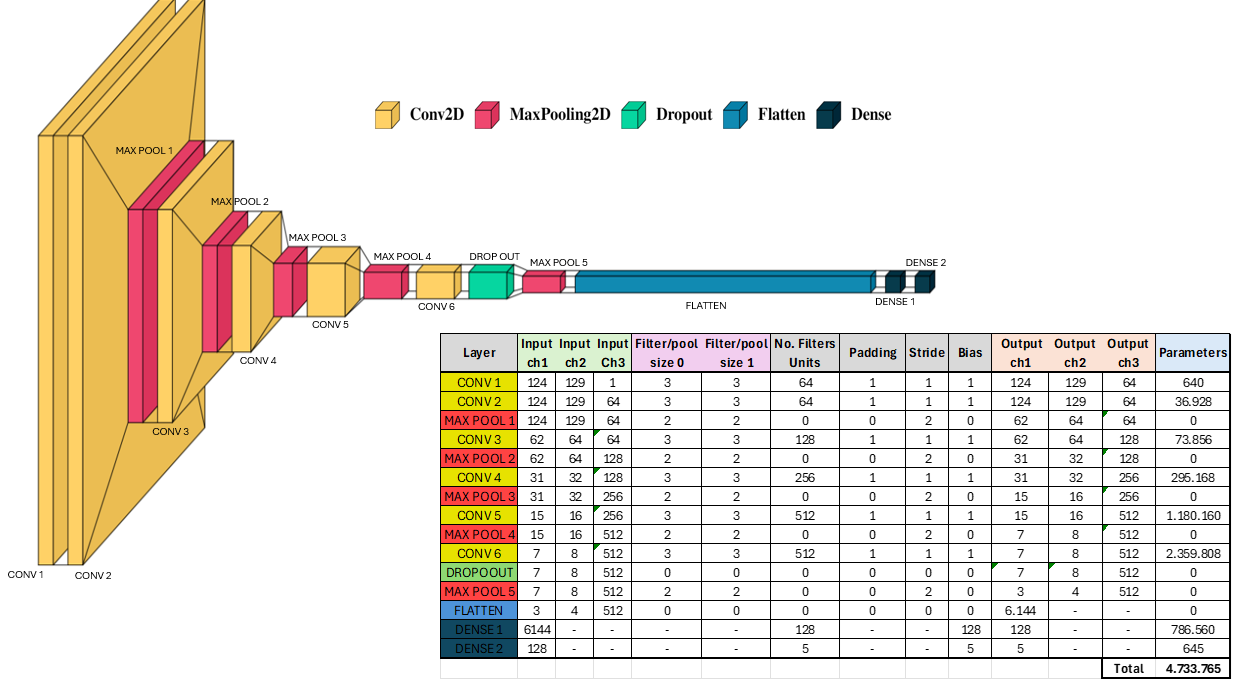

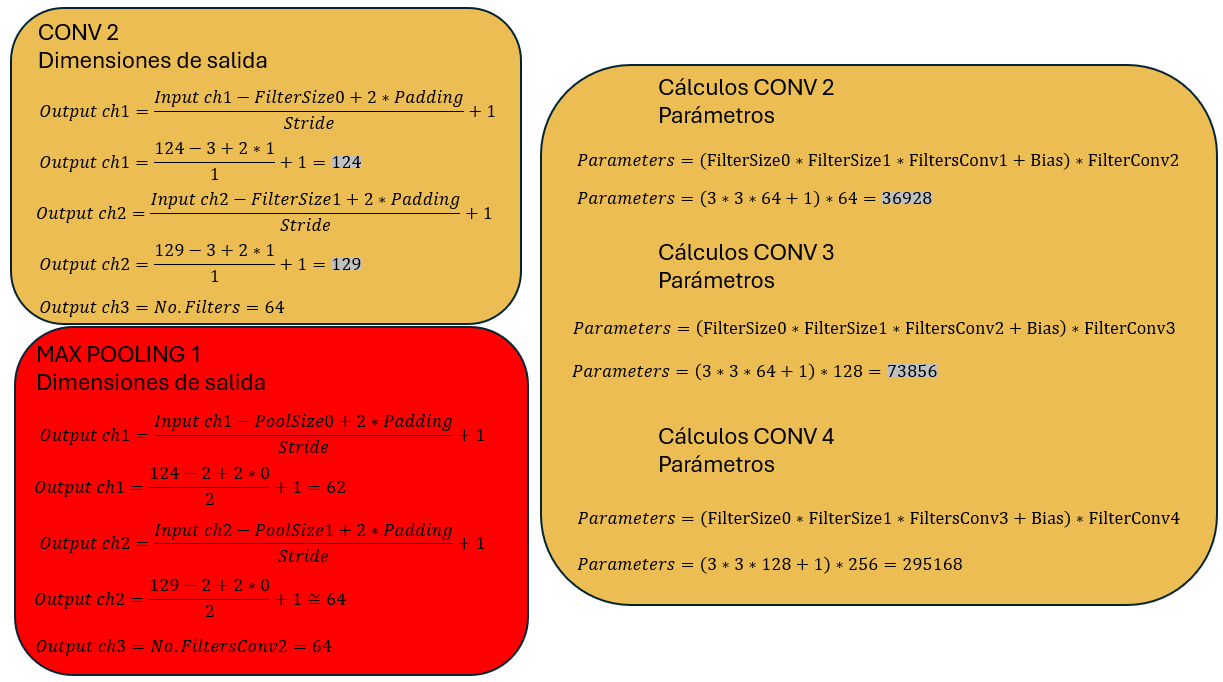

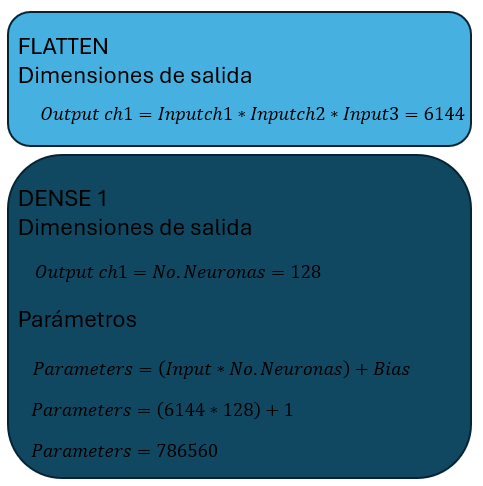

In [ ]:
#Se compila el modelo
modelo.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
history = modelo.fit(Xtrain,Ytrain,
                     validation_data=(Xtest,Ytest),
                     epochs=20,
                     batch_size=None)

Epoch 1/20
13/13 [==============================] - 4s 122ms/step - loss: 1.3123 - accuracy: 0.3744 - val_loss: 1.2688 - val_accuracy: 0.5780
Epoch 2/20
13/13 [==============================] - 1s 101ms/step - loss: 0.9876 - accuracy: 0.6382 - val_loss: 0.6586 - val_accuracy: 0.8165
Epoch 3/20
13/13 [==============================] - 1s 101ms/step - loss: 0.7181 - accuracy: 0.7513 - val_loss: 0.5924 - val_accuracy: 0.8257
Epoch 4/20
13/13 [==============================] - 1s 93ms/step - loss: 0.4680 - accuracy: 0.8116 - val_loss: 0.8110 - val_accuracy: 0.7798
Epoch 5/20
13/13 [==============================] - 1s 100ms/step - loss: 0.5638 - accuracy: 0.7940 - val_loss: 0.4482 - val_accuracy: 0.8349
Epoch 6/20
13/13 [==============================] - 1s 94ms/step - loss: 0.3827 - accuracy: 0.8543 - val_loss: 0.4099 - val_accuracy: 0.8899
Epoch 7/20
13/13 [==============================] - 1s 101ms/step - loss: 0.2339 - accuracy: 0.9146 - val_loss: 0.4190 - val_accuracy: 0.8899
Epoch 8/

In [ ]:
def plot_accu(historia, color_accu, color_val_accu, titulo):
 plt.plot(historia.history["accuracy"],color_accu,
          label='Pérdida Entrenamiento')
 plt.plot(historia.history["val_accuracy"],color_val_accu,
          label='Pérdida Validacion')
 plt.xlabel('Epocas')
 plt.ylabel('Accu')
 plt.title(titulo)
 plt.legend()

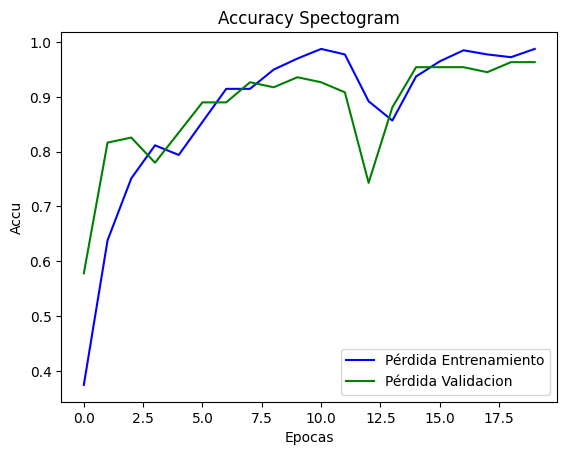

In [ ]:
plot_accu(history, 'b', 'g', 'Accuracy Spectogram')

In [ ]:
def plot_report(ytest, ypredict, color, titulo):
  labels = ['bateria','flauta','fondo','guitarra','piano']

  #Accuracy of the predicted values
  print(classification_report(ytest,
                              ypredict,
                              target_names = labels)) # Precision , Recall, F1-Score & Support

  cm = confusion_matrix(ytest,
                        ypredict)
  disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
  disp_cm.plot(cmap=color)
  plt.title(titulo)
  plt.show()

4/4 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

     bateria       1.00      0.96      0.98        25
      flauta       0.96      1.00      0.98        23
       fondo       1.00      0.93      0.96        14
    guitarra       1.00      0.92      0.96        24
       piano       0.88      1.00      0.94        23

    accuracy                           0.96       109
   macro avg       0.97      0.96      0.96       109
weighted avg       0.97      0.96      0.96       109



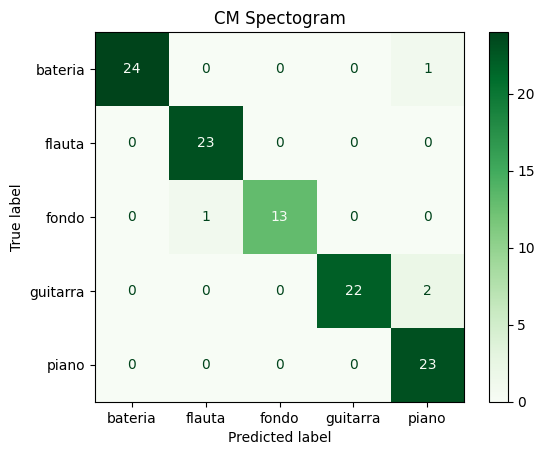

In [ ]:
ypredic=modelo.predict(Xtest)

y_test_class = np.argmax(Ytest,axis=1)
y_pred_class = np.argmax(ypredic,axis=1)

plot_report(y_test_class, y_pred_class, 'Greens', 'CM Spectogram')

<h1>MFCC</h1>

In [ ]:
def loadfiles_mfcc(path, wave_axis1, wave_axis2):
  directory = path
  files = os.listdir(directory)
  files.sort()
  cantidadFiles = len(files)
  # Variable donde se almacenaron los datos leidos de los archivos *.json

  batch_size, num_samples, sample_rate = 32, 32000, 16000.0
  Datos=np.zeros((cantidadFiles, wave_axis1, wave_axis2))
  i = 0
  for file in files:
    RutaFile=directory + file
    wave = load_wav_16k_mono(RutaFile)
    espectrograma, stfts = preprocess(wave)

    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, wave_axis2
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                                        num_spectrogram_bins,
                                                                        sample_rate,
                                                                        lower_edge_hertz,
                                                                    64    upper_edge_hertz)
    mel_spectrograms = tf.tensordot(espectrograma,
                                    linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(espectrograma.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :wave_axis2]
    Datos[i,:,:]=mfccs
    i+=1
  X=tf.expand_dims(Datos, axis=3)

  return X

In [ ]:
Xtrain_mfcc = loadfiles_mfcc(training_path,
                             espectrograma.shape[0],
                             espectrograma.shape[1])
Xtest_mfcc = loadfiles_mfcc(test_path,
                            espectrograma.shape[0],
                            espectrograma.shape[1])

Text(0.5, 1.0, 'Flauta')

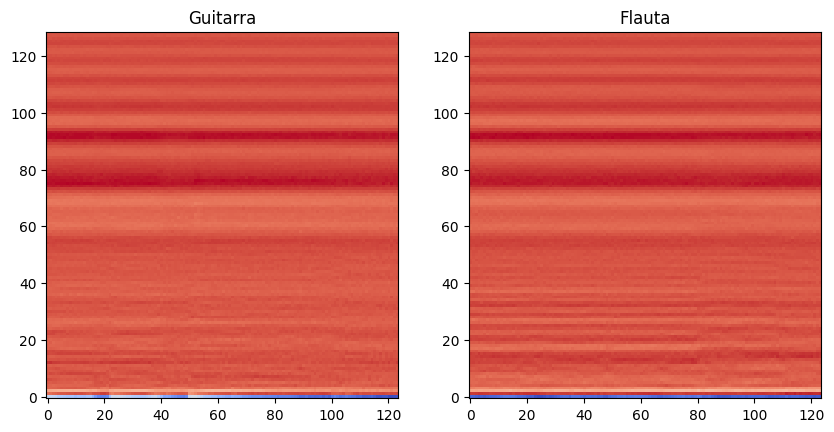

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
mfcc_data1= np.swapaxes(Xtrain_mfcc[300], 0 ,1)
ax1 = plt.imshow(mfcc_data1,
                interpolation='nearest',
                cmap=cm.coolwarm,
                origin='lower')
plt.title('Guitarra')

plt.subplot(1,2,2)
mfcc_data2= np.swapaxes(Xtrain_mfcc[100], 0 ,1)
ax2 = plt.imshow(mfcc_data2,
                interpolation='nearest',
                cmap=cm.coolwarm,
                origin='lower')
plt.title('Flauta')

In [ ]:
#Definición del modelo
modelo_mfcc = keras.models.Sequential()
modelo_mfcc.add(keras.layers.Conv2D(input_shape=(Xtrain.shape[1],
                                            Xtrain.shape[2],
                                            Xtrain.shape[3]),
                                            filters=64,kernel_size=(3,3),
                                            padding="same",
                                            activation="relu"))
modelo_mfcc.add(keras.layers.Conv2D(filters=64,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo_mfcc.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo_mfcc.add(keras.layers.Conv2D(filters=128,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo_mfcc.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo_mfcc.add(keras.layers.Conv2D(filters=256,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo_mfcc.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo_mfcc.add(keras.layers.Conv2D(filters=512,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo_mfcc.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo_mfcc.add(keras.layers.Conv2D(filters=512,
                               kernel_size=(3,3),
                               padding="same",
                               activation="relu"))
modelo_mfcc.add(Dropout(0.1))
modelo_mfcc.add(keras.layers.MaxPooling2D(pool_size=(2,2),
                                     strides=(2,2)))

modelo_mfcc.add(keras.layers.Flatten())
modelo_mfcc.add(keras.layers.Dense(units=128,activation="relu"))
modelo_mfcc.add(keras.layers.Dense(units=5, activation="softmax"))

In [ ]:
modelo_mfcc.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
history_mfcc = modelo_mfcc.fit(Xtrain_mfcc,Ytrain,
                     validation_data=(Xtest_mfcc,Ytest),
                     epochs=20,
                     batch_size=None)

Epoch 1/20
13/13 [==============================] - 17s 442ms/step - loss: 1.8050 - accuracy: 0.2362 - val_loss: 1.5970 - val_accuracy: 0.2110
Epoch 2/20
13/13 [==============================] - 1s 100ms/step - loss: 1.5524 - accuracy: 0.2940 - val_loss: 1.4299 - val_accuracy: 0.5229
Epoch 3/20
13/13 [==============================] - 1s 94ms/step - loss: 1.1452 - accuracy: 0.5603 - val_loss: 0.9621 - val_accuracy: 0.5872
Epoch 4/20
13/13 [==============================] - 1s 98ms/step - loss: 0.7892 - accuracy: 0.6533 - val_loss: 0.6033 - val_accuracy: 0.7615
Epoch 5/20
13/13 [==============================] - 1s 99ms/step - loss: 0.5767 - accuracy: 0.7739 - val_loss: 0.3901 - val_accuracy: 0.8716
Epoch 6/20
13/13 [==============================] - 1s 103ms/step - loss: 0.4214 - accuracy: 0.8015 - val_loss: 0.2481 - val_accuracy: 0.9266
Epoch 7/20
13/13 [==============================] - 1s 101ms/step - loss: 0.5057 - accuracy: 0.8015 - val_loss: 0.3674 - val_accuracy: 0.8899
Epoch 8/

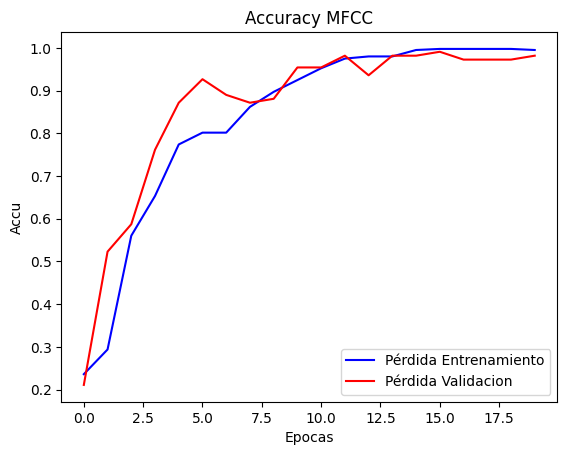

In [ ]:
#Se grafica el accuracy del modelo con MFCC
plot_accu(history_mfcc, 'b', 'r', 'Accuracy MFCC')

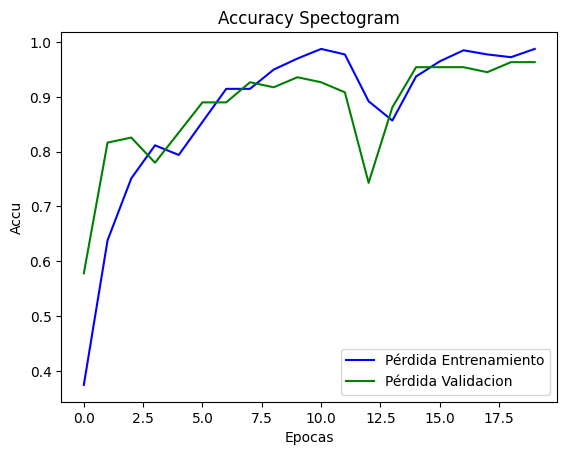

In [ ]:
#Se grafica el accuracy del modelo con espectograma
plot_accu(history, 'b', 'g', 'Accuracy Spectogram')

4/4 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

     bateria       1.00      0.96      0.98        25
      flauta       0.96      1.00      0.98        23
       fondo       1.00      0.93      0.96        14
    guitarra       1.00      1.00      1.00        24
       piano       0.96      1.00      0.98        23

    accuracy                           0.98       109
   macro avg       0.98      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109



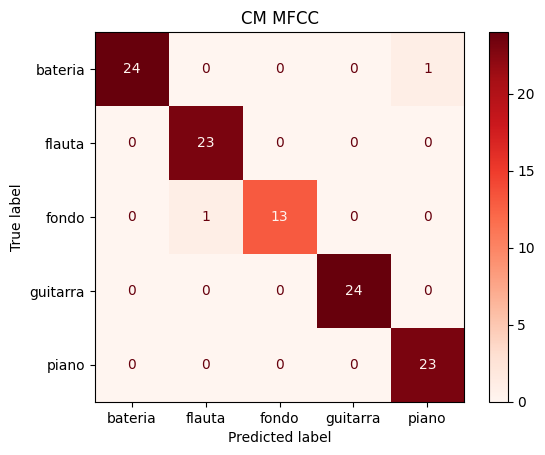

              precision    recall  f1-score   support

     bateria       1.00      0.96      0.98        25
      flauta       0.96      1.00      0.98        23
       fondo       1.00      0.93      0.96        14
    guitarra       1.00      0.92      0.96        24
       piano       0.88      1.00      0.94        23

    accuracy                           0.96       109
   macro avg       0.97      0.96      0.96       109
weighted avg       0.97      0.96      0.96       109



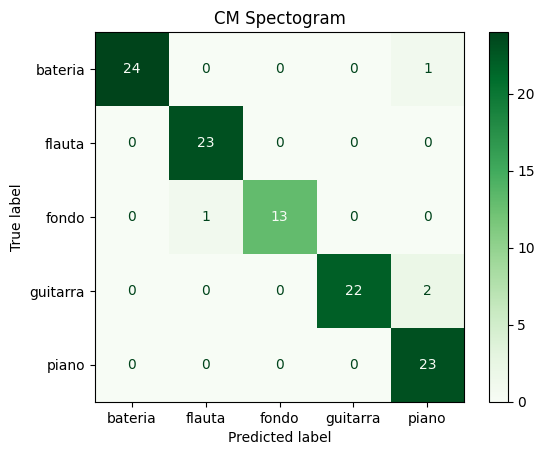

In [ ]:
ypredict_mfcc=modelo_mfcc.predict(Xtest_mfcc)

y_test_class = np.argmax(Ytest,axis=1)
y_pred_mfcc_class = np.argmax(ypredict_mfcc,axis=1)

#Se grafican las matrices de confusión del modelo con espectograma y el modelo con MFCC
plot_report(y_test_class, y_pred_mfcc_class, 'Reds', 'CM MFCC')
plot_report(y_test_class, y_pred_class, 'Greens', 'CM Spectogram')

Link al modelo de EdgeImpulse:

https://studio.edgeimpulse.com/public/392508/live